In [16]:
import pandas as pd
import numpy as np
import scipy

from pandas_datareader import data, wb

In [17]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
#
# Real ticker data
#
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime.now()

price_data = data.DataReader('SPY', 'yahoo', start, end)
adjclose_series = price_data['Adj Close']
adjclose_series.name = 'close'

df = pd.DataFrame(adjclose_series)

box_size = 1

box_start = 0
box_start_idx = None

box_end = 0
box_quantity = 0

temp_l = []

column_flag = None

reversal_value = 1

reversal_flag = False

column_index = 0

# Simple point and figure algorihtm


for i in range(len(df)):
    if box_start == 0:
        box_start = df.close[i]

    else:
        box_start = box_start
        price_move = df.close[i] - box_start

        # First of all we need to set box size.
        # Then calculate price movement.
        # If price movement is more or equal than box size - renko bar(or bars) will be added

        if np.abs(price_move) >= box_size:

            # After we calculate box_quantity(price move divided by box size)
            # This number defines how much pnf boxes will be registred
            box_quantity = np.int32(np.floor(np.abs(price_move / box_size)))
            box_date = df.close.index[i]

            if column_flag == 'x' and reversal_flag == False:

                # Reversal check
                if price_move < 0 and box_quantity >= reversal_value:
                    reversal_flag = True
                    box_start = temp_l[-1]['open']
                    column_index += 1

                elif price_move > 0:
                    reversal_flag = False

                    for b in range(int(box_quantity)):

                        if box_end == 0:
                            d = {'date': box_date, 'open': box_start, 'close': box_start + box_size,
                                 'type': column_flag, 'column_index': column_index}

                            box_end = d['close']
                            temp_l.append(d)

                        else:
                            d = {'date': box_date, 'open': box_end, 'close': box_end + box_size,
                                 'type': column_flag, 'column_index': column_index}

                            box_end = d['close']
                            temp_l.append(d)

            if column_flag == 'o' and reversal_flag == False:

                # Reversal check
                if price_move > 0 and box_quantity >= reversal_value:
                    reversal_flag = True
                    box_start = temp_l[-1]['open']
                    column_index += 1

                elif price_move < 0:
                    reversal_flag = False

                    for b in range(int(box_quantity)):

                        if box_end == 0:
                            d = {'date': box_date, 'open': box_start, 'close': box_start - box_size,
                                 'type': column_flag, 'column_index': column_index}

                            box_end = d['close']
                            temp_l.append(d)

                        else:
                            d = {'date': box_date, 'open': box_end, 'close': box_end - box_size,
                                 'type': column_flag, 'column_index': column_index}

                            box_end = d['close']
                            temp_l.append(d)

            if column_flag == None and reversal_flag == False:

                # Adding first column

                if price_move > 0:
                    column_flag = 'x'

                if price_move < 0:
                    column_flag = 'o'

                for b in range(int(box_quantity)):
                    if column_flag == 'x':

                        if box_end == 0:
                            d = {'date': box_date, 'open': box_start, 'close': box_start + box_size, 'type': column_flag,
                                 'column_index': column_index}

                            box_end = d['close']
                            temp_l.append(d)

                        else:
                            d = {'date': box_date, 'open': box_end, 'close': box_end + box_size, 'type': column_flag,
                                 'column_index': column_index}

                            box_end = d['close']
                            temp_l.append(d)

                    if column_flag == 'o':

                        if box_end == 0:
                            d = {'date': box_date, 'open': box_start, 'close': box_start - box_size,
                                 'type': column_flag, 'column_index': column_index}

                            box_end = d['close']
                            temp_l.append(d)

                        else:
                            d = {'date': box_date, 'open': box_end, 'close': box_end - box_size, 'type': column_flag,
                                 'column_index': column_index}

                            box_end = d['close']
                            temp_l.append(d)

            # Handling the reversals
            if reversal_flag == True:
                if column_flag == 'x':

                    column_flag = 'o'

                    for b in range(int(box_quantity)):
                            if box_end == 0:
                                d = {'date': box_date, 'open': box_start, 'close': box_start - box_size,
                                     'type': column_flag, 'column_index': column_index}

                                box_end = d['close']
                                temp_l.append(d)

                            else:
                                d = {'date': box_date, 'open': box_end, 'close': box_end - box_size,
                                     'type': column_flag, 'column_index': column_index}

                                box_end = d['close']
                                temp_l.append(d)

                if column_flag == 'o':

                    column_flag = 'x'

                    for b in range(int(box_quantity)):
                        if box_end == 0:
                            d = {'date': box_date, 'open': box_start, 'close': box_start + box_size,
                                 'type': column_flag, 'column_index': column_index}

                            box_end = d['close']
                            temp_l.append(d)

                        else:
                            d = {'date': box_date, 'open': box_end, 'close': box_end + box_size,
                                 'type': column_flag, 'column_index': column_index}

                            box_end = d['close']
                            temp_l.append(d)

                reversal_flag = False

        box_start = df.close[i]
                
pnf_df = pd.DataFrame(temp_l)                
pnf_df.index = pnf_df.column_index

In [39]:
pnf_df

,close,column_index,date,open,type
column_index,,,,,
0,99.694113,0,2010-01-15,100.694113,o
1,100.694113,1,2010-01-19,99.694113,x
2,99.694113,2,2010-01-20,100.694113,o
2,100.694113,2,2010-01-20,99.694113,x
3,99.694113,3,2010-01-21,100.694113,o
3,100.694113,3,2010-01-21,99.694113,x
4,99.694113,4,2010-01-22,100.694113,o
4,98.694113,4,2010-01-22,99.694113,o
4,99.694113,4,2010-01-22,98.694113,x


In [105]:
import pandas as pd
import numpy as np
import scipy

from pandas_datareader import data, wb
import datetime
#
# random time series
#
date = pd.date_range(start='2015-01', end='2015-05', freq='D')
price = np.random.randint(-100, 100, size=len(date))
df = pd.DataFrame(price, index=date, columns=['close'])
df = df.cumsum()

#
# Real ticker data
#
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime.now()

price_data = data.DataReader('SPY', 'yahoo', start, end)
adjclose_series = price_data['Adj Close']
adjclose_series.name = 'close'

df = pd.DataFrame(adjclose_series)



box_size = 2

box_start = 0
box_start_idx = None

box_end = 0
box_quantity = 0

temp_l = []

column_flag = None

reversal_value = box_size * 2

reversal_flag = False

column_index = 0

# Simple point and figure algorihtm


for i in range(len(df)):
    if box_start == 0:
        box_start = df.close[i]

    else:
        box_start = box_start
        price_move = df.close[i] - box_start

        # First of all we need to set box size.
        # Then calculate price movement.
        # If price movement is more or equal than box size - renko bar(or bars) will be added

        if np.abs(price_move) >= box_size:

            # After we calculate box_quantity(price move divided by box size)
            # This number defines how much pnf boxes will be registred
            box_quantity = np.int32(np.floor(np.abs(price_move / box_size)))
            box_date = df.close.index[i]

            if column_flag == 'x' and reversal_flag == False:

                # Reversal check
                if price_move < 0 and box_quantity >= reversal_value:
                    reversal_flag = True
                    box_start = temp_l[-1]['open']
                    

                elif price_move > 0:
                    reversal_flag = False

                    for b in range(int(box_quantity)):

                        if box_end == 0:
                            d = {'date': box_date, 'open': box_start, 'close': box_start + box_size,
                                 'type': column_flag, 'column_index': column_index}

                            box_end = d['close']
                            temp_l.append(d)

                        else:
                            d = {'date': box_date, 'open': box_end, 'close': box_end + box_size,
                                 'type': column_flag, 'column_index': column_index}

                            box_end = d['close']
                            temp_l.append(d)

            if column_flag == 'o' and reversal_flag == False:

                # Reversal check
                if price_move > 0 and box_quantity >= reversal_value:
                    reversal_flag = True
                    box_start = temp_l[-1]['open']
                    
                elif price_move < 0:
                    reversal_flag = False

                    for b in range(int(box_quantity)):

                        if box_end == 0:
                            d = {'date': box_date, 'open': box_start, 'close': box_start - box_size,
                                 'type': column_flag, 'column_index': column_index}

                            box_end = d['close']
                            temp_l.append(d)

                        else:
                            d = {'date': box_date, 'open': box_end, 'close': box_end - box_size,
                                 'type': column_flag, 'column_index': column_index}

                            box_end = d['close']
                            temp_l.append(d)

            if column_flag == None and reversal_flag == False:

                # Adding first column

                if price_move > 0:
                    column_flag = 'x'

                if price_move < 0:
                    column_flag = 'o'

                for b in range(int(box_quantity)):
                    if column_flag == 'x':

                        if box_end == 0:
                            d = {'date': box_date, 'open': box_start, 'close': box_start + box_size, 'type': column_flag,
                                 'column_index': column_index}

                            box_end = d['close']
                            temp_l.append(d)

                        else:
                            d = {'date': box_date, 'open': box_end, 'close': box_end + box_size, 'type': column_flag,
                                 'column_index': column_index}

                            box_end = d['close']
                            temp_l.append(d)

                    if column_flag == 'o':

                        if box_end == 0:
                            d = {'date': box_date, 'open': box_start, 'close': box_start - box_size,
                                 'type': column_flag, 'column_index': column_index}

                            box_end = d['close']
                            temp_l.append(d)

                        else:
                            d = {'date': box_date, 'open': box_end, 'close': box_end - box_size, 'type': column_flag,
                                 'column_index': column_index}

                            box_end = d['close']
                            temp_l.append(d)

            # Handling the reversals
            if reversal_flag == True:
                column_index += 1
                
                if column_flag == 'x':

                    column_flag = 'o'

                    for b in range(int(box_quantity)):
                            if box_end == 0:
                                d = {'date': box_date, 'open': box_start, 'close': box_start - box_size,
                                     'type': column_flag, 'column_index': column_index}

                                box_end = d['close']
                                temp_l.append(d)

                            else:
                                d = {'date': box_date, 'open': box_end, 'close': box_end - box_size,
                                     'type': column_flag, 'column_index': column_index}

                                box_end = d['close']
                                temp_l.append(d)

                if column_flag == 'o':

                    column_flag = 'x'

                    for b in range(int(box_quantity)):
                        if box_end == 0:
                            d = {'date': box_date, 'open': box_start, 'close': box_start + box_size,
                                 'type': column_flag, 'column_index': column_index}

                            box_end = d['close']
                            temp_l.append(d)

                        else:
                            d = {'date': box_date, 'open': box_end, 'close': box_end + box_size,
                                 'type': column_flag, 'column_index': column_index}

                            box_end = d['close']
                            temp_l.append(d)

                reversal_flag = False
        try:
            box_start = temp_l[-1]['open']
            
        except IndexError:
            box_start = df.close[i]


#print(temp_l)


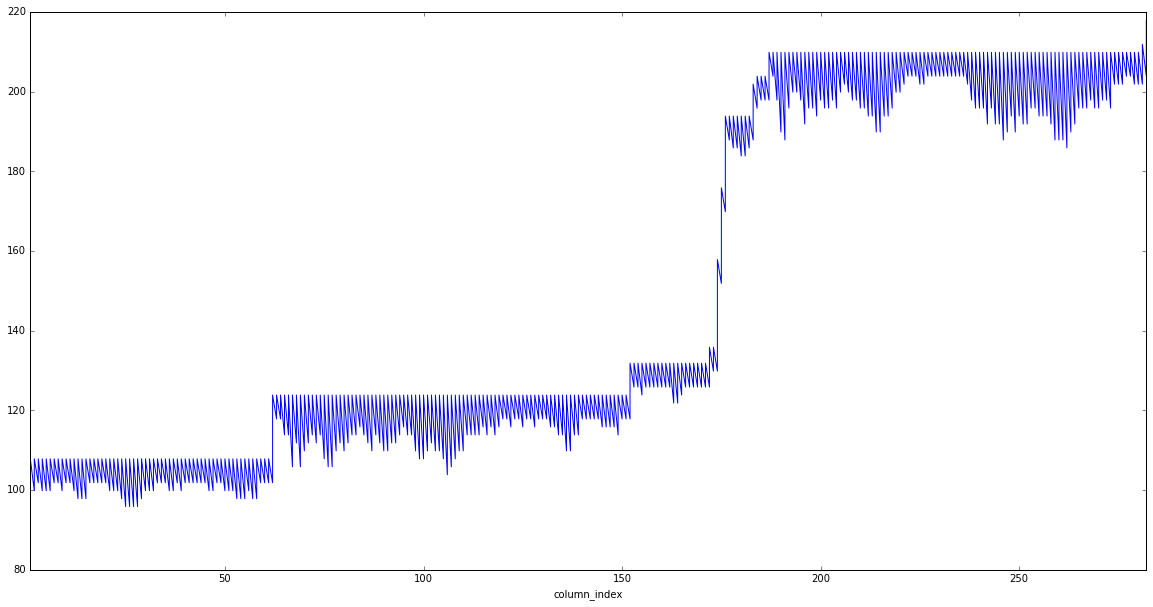

In [106]:
pnf_df = pd.DataFrame(temp_l)                
pnf_df.index = pnf_df.column_index
#pnf_df.groupby(pnf_df.index).las().close.plot()
figsize(20,10)
pnf_df[pnf_df.type == 'x'].close.plot()

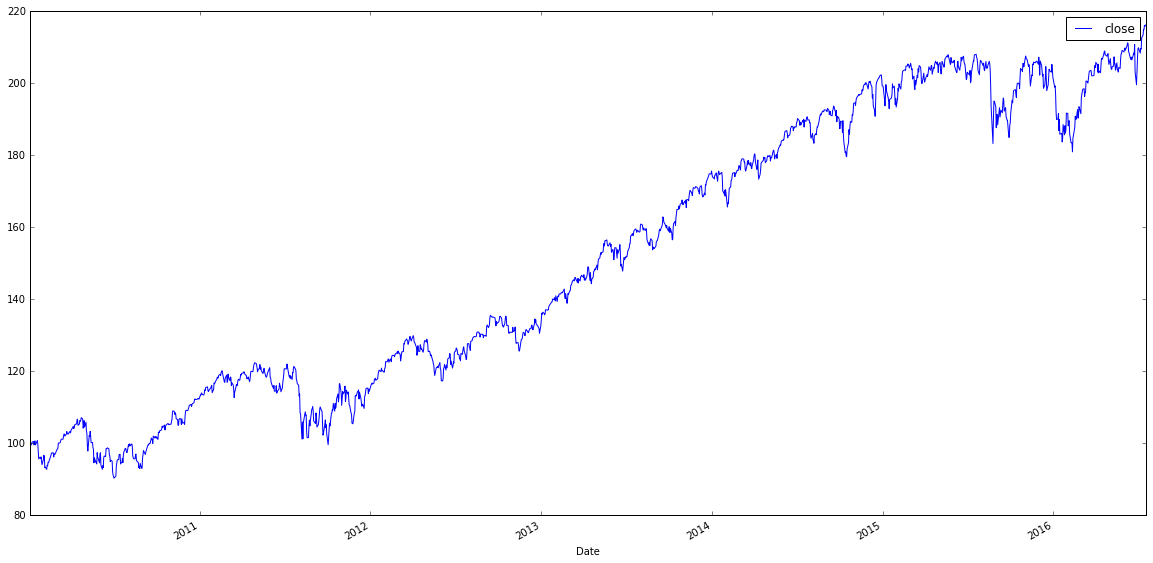

In [86]:
df.plot()

In [3]:
col1_y = np.arange(20, step=2)
idx1_x = [0] * len(col1_y)

col2_y = np.arange(0,40, step=2)
idx2_x = [1] * len(col2_y)
#idx2_x = np.place(idx2_x, idx2_x == 0, [1])

In [4]:
col2_y

array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
       34, 36, 38])

In [103]:
import plotly.plotly as py
import plotly.graph_objs as go

# Create random data with numpy
import numpy as np

py.sign_in('tmqr', '8rctfyu197')


trace1 = go.Scatter(
    x = pnf_df[pnf_df.type == 'o'].index,
    y = pnf_df[pnf_df.type == 'o'].close,
    name='Down',
    mode = 'markers',
    marker = dict(symbol="o", size=10, color = 'rgba(255, 0, 0, 0.9)')
)

trace2 = go.Scatter(
    x = pnf_df[pnf_df.type == 'x'].index,
    y = pnf_df[pnf_df.type == 'x'].close,
    name = 'Up',
    mode = 'markers',
    marker = dict(symbol="x", size=10, color = 'rgba(0, 255, 0, 0.9)')
)

data = [trace1, trace2]

layout = go.Layout(
    title="Point And Figure",
    xaxis=dict( autotick=False, autorange=True
        )
    )
fig = go.Figure(data=data, layout=layout)
# Plot and embed in ipython notebook!
py.iplot(fig, filename='basic-scatter')

In [104]:
trace = go.Scatter(
    x = df.index,
    y = df.close
)

data = [trace]

# Plot and embed in ipython notebook!
py.iplot(data, filename='basic-line')